### Advanced Finding Lane Lines

Welcome, This is Mertcan Cibooglu's udacity second project pipeline.



The goals / steps of this project are the following:

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.  
Apply a distortion correction to raw images.  
Use color transforms, gradients, etc., to create a thresholded binary image.  
Apply a perspective transform to rectify binary image ("birds-eye view").  
Detect lane pixels and fit to find the lane boundary.  
Determine the curvature of the lane and vehicle position with respect to center.  
Warp the detected lane boundaries back onto the original image.  
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position  

### We have Undisortion parameters now, before warp color and gradient threshold will be applied

### Distortion correction to raw image

In [50]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import cv2
%matplotlib inline
import math
import os
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
SaveDirectory = 'output_images/'

#img = mpimg.imread('test_images/straight_lines1.jpg')  ## just test an example
img = mpimg.imread('test_images/test4.jpg')  ## just test an example
def disortion(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    dist_pickle = pickle.load( open( "camera_cal\dist_cal_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    dst = cv2.undistort(image, mtx, dist, None, mtx)

    return dst


Text(0.5, 1.0, 'Undistorted Image')

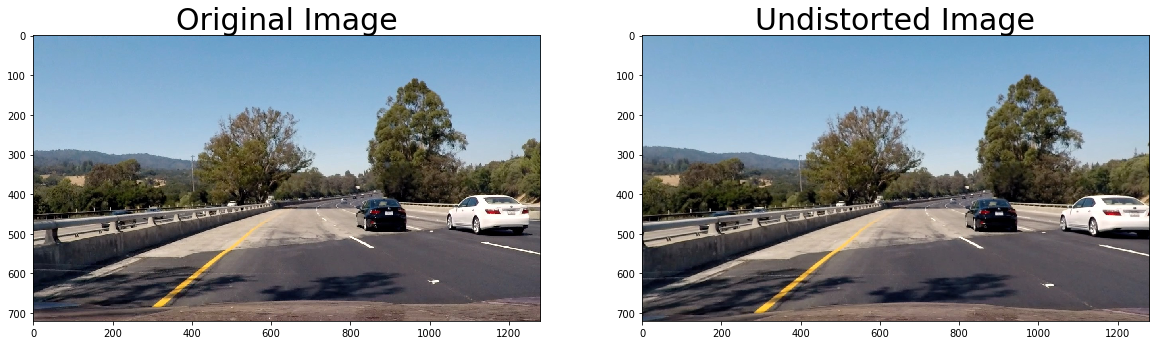

In [51]:
disorted_img=disortion(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(disorted_img)
ax2.set_title('Undistorted Image', fontsize=30)



In [52]:

cv2.imwrite(SaveDirectory+'imgb.png', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
cv2.imwrite(SaveDirectory+'disorted_img.png', cv2.cvtColor(disorted_img, cv2.COLOR_BGR2RGB))

True

### Sobel Threshold

In [53]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    if orient=='x':
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    elif orient=='y':
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
        
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return grad_binary



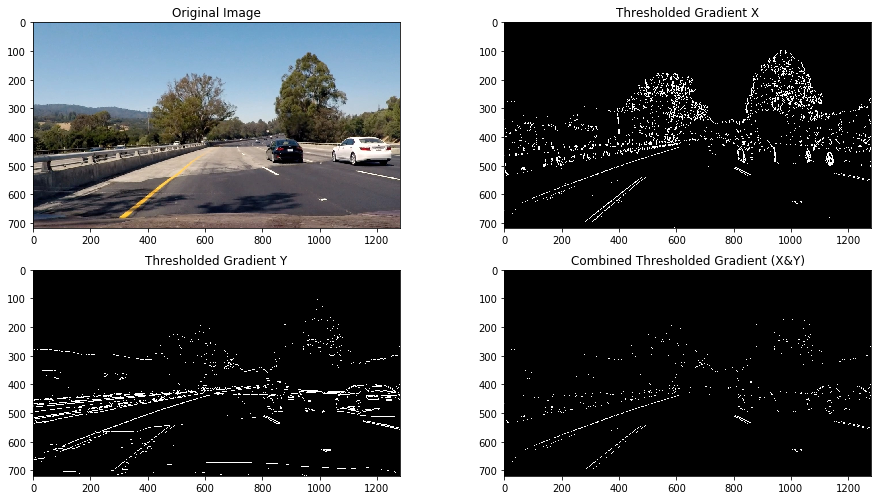

In [54]:

ksize = 3 # Choose a larger odd number to smooth gradient measurements
gradx = abs_sobel_thresh(disorted_img, orient='x', sobel_kernel=9, thresh=(30, 255))
grady = abs_sobel_thresh(disorted_img, orient='y', sobel_kernel=9, thresh=(50, 200))
combinedxy=np.zeros_like(gradx)
combinedxy[((gradx == 1) & (grady == 1)) ] = 1
# Run the function
#grad_binary = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
# Plot the result
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7))
#f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(gradx, cmap='gray')
ax2.set_title('Thresholded Gradient X', fontsize=12)
ax3.imshow(grady, cmap='gray')
ax3.set_title('Thresholded Gradient Y', fontsize=12)
ax4.imshow(combinedxy, cmap='gray')
ax4.set_title('Combined Thresholded Gradient (X&Y)', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [55]:
cv2.imwrite(SaveDirectory+'gradx.png',gradx * 255)
cv2.imwrite(SaveDirectory+'grady.png',grady * 255)
cv2.imwrite(SaveDirectory+'combinedxy.png',combinedxy * 255)

True

### Direction and Magnitude threshold

In [56]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir=np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return dir_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel /np.max(mag_sobel ))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mag_binary

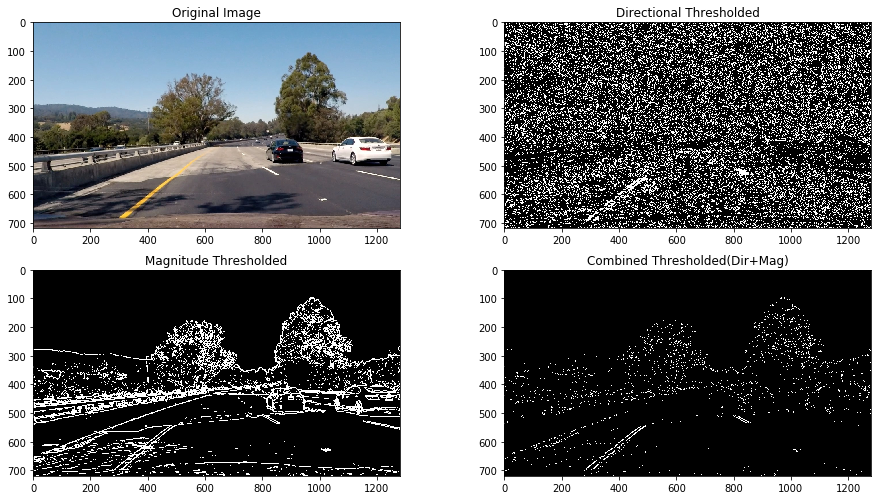

In [57]:

dir_tr=dir_threshold(disorted_img,sobel_kernel=9, thresh=(0.8, 1.2))  #(0, np.pi/2))
mag_tr=mag_thresh(disorted_img,sobel_kernel=3, mag_thresh=(25, 200)) #(40, 90)---- 80 150 now
combinedmagdir=np.zeros_like(gradx)
combinedmagdir[((mag_tr == 1) & (dir_tr == 1))] = 1

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7))
#f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=12)
ax2.imshow(dir_tr, cmap='gray')
ax2.set_title('Directional Thresholded', fontsize=12)
ax3.imshow(mag_tr, cmap='gray')
ax3.set_title('Magnitude Thresholded', fontsize=12)
ax4.imshow(combinedmagdir, cmap='gray')
ax4.set_title('Combined Thresholded(Dir+Mag)', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [58]:
cv2.imwrite(SaveDirectory+'dir_tr.png',dir_tr * 255)
cv2.imwrite(SaveDirectory+'mag_tr.png',mag_tr * 255)
cv2.imwrite(SaveDirectory+'combinedmagdir.png',combinedmagdir * 255)

True

### Color threshold

In [59]:
def color_thresh(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img , cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    #return color_binary
    return s_binary


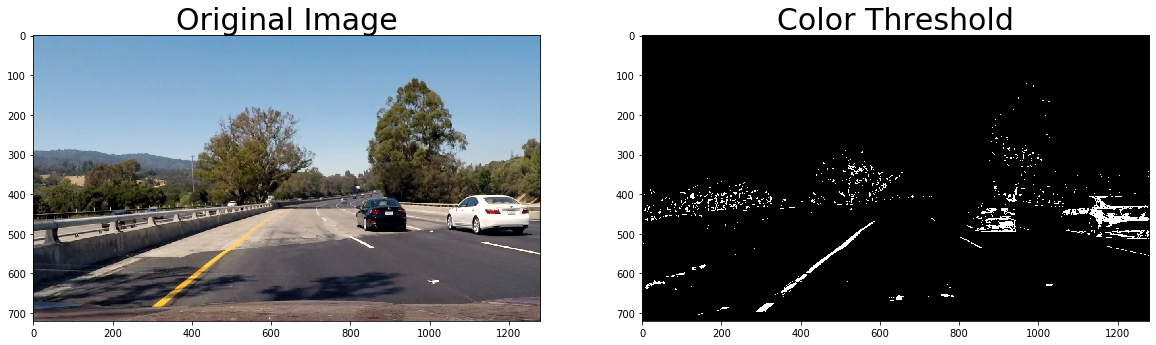

In [81]:
color_tr=color_thresh(disorted_img,s_thresh=(170, 255),sx_thresh=(20, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(color_tr,cmap='gray')
ax2.set_title('Color Threshold', fontsize=30)
plt.savefig(SaveDirectory+'color_tr.png') ##save plot

In [61]:
#cv2.imwrite(SaveDirectory+'color_tr.png',color_tr * 255)

True

### Combination of Color and Gradient Thresholds

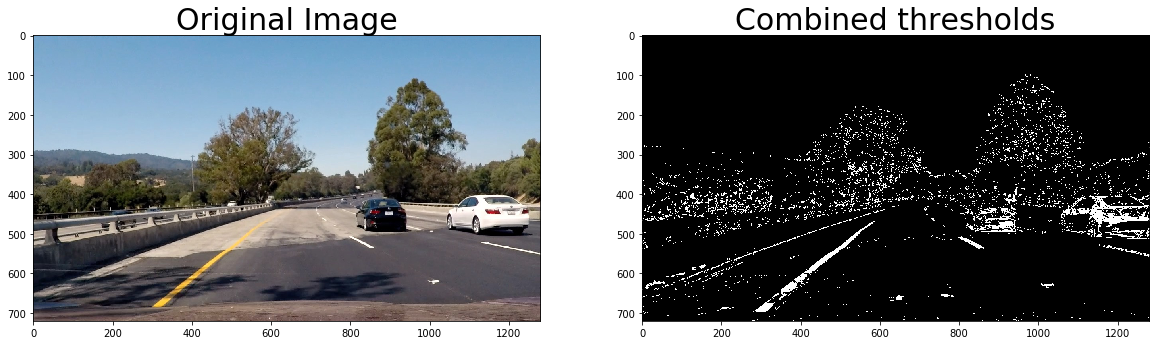

In [82]:
combined = np.zeros_like(dir_tr)
#combined[((gradx == 1) & (grady == 1)) | ((mag_tr == 1) & (dir_tr == 1))] = 1
combined[((gradx == 1) & (grady == 1)) |  (color_tr==1)| ((mag_tr == 1) & (dir_tr == 1))] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(combined,cmap='gray')
ax2.set_title('Combined thresholds', fontsize=30)
plt.savefig(SaveDirectory+'combined.png') ##save plot

In [63]:
#cv2.imwrite(SaveDirectory+'combined.png',combined * 255)

True

### Perspective transform

In [64]:
def corners_unwarp(img,src,dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    img_size=(img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)  
    return warped, M, Minv

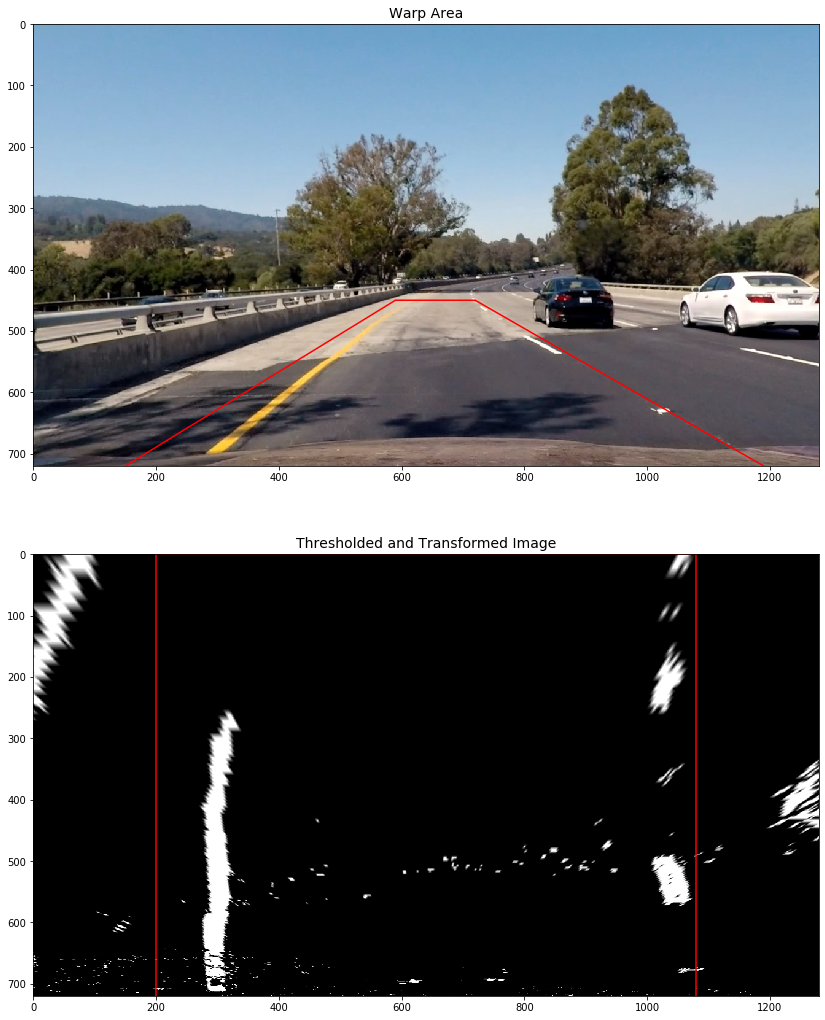

In [72]:
src = np.float32(
        [[ 150, 720],
         [590,450],
         [720, 450],
        [1190, 720]])
dst = np.float32(
                [[200,720],
                 [200,0],
                 [1080,0],
                 [1080,720]])



top_down, perspective_M, Minv = corners_unwarp(combined,src,dst)



warp_area_check=disorted_img
f, (ax2, ax3) = plt.subplots(2, 1, figsize=(12, 15))
#f.tight_layout()
#ax1.imshow(img)
#ax1.set_title('Original Image', fontsize=14)
ax2.plot([src[3][0], src[2][0], src[1][0],src[0][0]], [src[3][1], src[2][1], src[1][1], src[0][1]],'r')
ax2.imshow(warp_area_check)
ax2.set_title('Warp Area', fontsize=14)

ax3.plot([dst[3][0], dst[2][0], dst[1][0], dst[0][0]], [dst[3][1], dst[2][1], dst[1][1], dst[0][1]],'r')
ax3.imshow(top_down,cmap='gray')
ax3.set_title('Thresholded and Transformed Image', fontsize=14)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig(SaveDirectory+'warped.png') ##save plot

<Figure size 432x288 with 0 Axes>

### Sliding Window Method for Lane Lines

In [69]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  
        win_xleft_high = leftx_current+margin  
        win_xright_low = rightx_current-margin 
        win_xright_high = rightx_current+margin  
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit=np.polyfit(lefty, leftx, 2) ###NOTE, NORMAL polyfit takes x first
    right_fit = np.polyfit(righty, rightx, 2) ### AXIS INVERSE

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


left lane parameters= [ 7.87861803e-05 -1.03576604e-01  3.31512289e+02]
right lane parameters= [ 2.56669400e-04 -1.60740397e-01  1.05507296e+03]


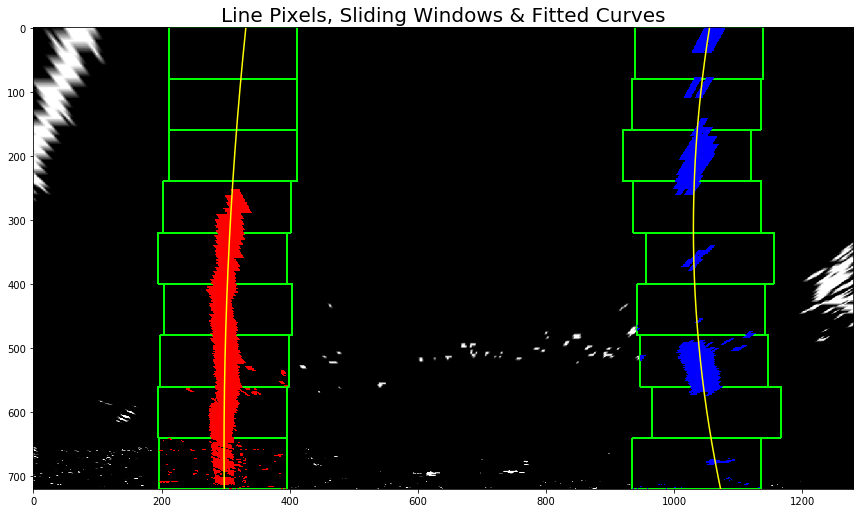

In [83]:
out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(top_down)

print("left lane parameters=",left_fit)
print("right lane parameters=",right_fit)

f, (ax1) = plt.subplots(1, 1, figsize=(15, 7))
f.tight_layout()

ax1.imshow(out_img, cmap='gray')
ax1.plot(left_fitx, ploty, color='yellow')
ax1.plot(right_fitx, ploty, color='yellow')
ax1.set_title('Line Pixels, Sliding Windows & Fitted Curves', fontsize=20)
plt.savefig(SaveDirectory+'slidewindow.png')

### Search from Prior Method

Using the full algorithm from before and starting fresh on every frame may seem inefficient, as the lane lines don't necessarily move a lot from frame to frame.

In the next frame of video we don't need to do a blind search again, but instead we can just search in a margin around the previous lane line position

In [84]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    
    return left_fitx, right_fitx, ploty


def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


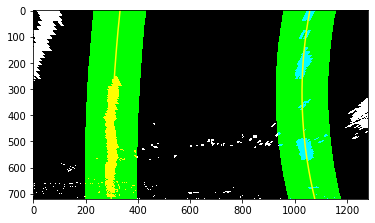

In [85]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(top_down)

# View your output
plt.imshow(result)
plt.savefig(SaveDirectory+'searchprior.png')

### Measuring Pixel Curvature

In [86]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!   
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


In [87]:
# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fit, right_fit)

print(left_curverad, right_curverad)

6347.18967833801 2076.243469179853


### Measuring Real World Curvature and Vehicle Position

In [88]:
def measure_curvature_real(ploty, left_fit, right_fit, left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension (from the warp destination points yend-yinit)(720-0)
    xm_per_pix = 3.7/880 # meters per pixel in x dimension (from the warp destination points xend-xinit)(1080-200)
    
       
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    #y_eval = np.max(ploty)
    y_eval = 690 # warped area cut at 690th pixel of y axis
    
    # calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    
    CenterFitx = (left_fitx + right_fitx)/2 # Average of the x values from left and right lines
    CenterFit = np.polyfit(ploty, CenterFitx, 2) # Curve fit for the average x values. This calculation can also be done by taking average of curve parameters of lef and right lines
    Center_curverad = ((1 + (2*CenterFit[0]*y_eval*ym_per_pix + CenterFit[1])**2)**1.5) / np.absolute(2*CenterFit[0])
    
    #calculation of vehicle position
    MidPoint = CenterFit[0]*y_eval**2 + CenterFit[1]*y_eval + CenterFit[2] # Bottom x point of the middle curve
    print(MidPoint)
    
    VehPos = (img.shape[1]/2 - MidPoint)*xm_per_pix # Calculation of how much the vehicle is drifted from the middle of the lane
    if VehPos > 0:
        VehLoc = "right"
    else:
        VehLoc = "left"
    
    return left_curverad, right_curverad, Center_curverad, VehPos, VehLoc



In [89]:

# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, Center_curverad, VehPos, VehLoc = measure_curvature_real(ploty, left_fit, right_fit, left_fitx, right_fitx)

print(left_curverad, 'm', right_curverad, 'm')

print("Radius of Left Line Curvature: %dm" % left_curverad)
print("Radius of Right Line Curvature: %dm" % right_curverad)
print("Radius of Center Curvature: %dm" % Center_curverad)
print("Vehicle is %.2fm %s of center" % (abs(VehPos), VehLoc))

681.958460975645
6439.906791464233 m 2010.6327035234362 m
Radius of Left Line Curvature: 6439m
Radius of Right Line Curvature: 2010m
Radius of Center Curvature: 3048m
Vehicle is 0.18m left of center


### Drawing

681.958460975645


Text(0.5, 1.0, 'Result')

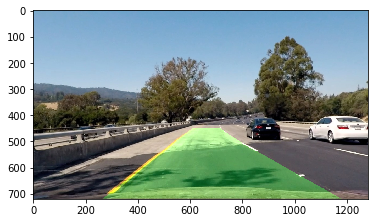

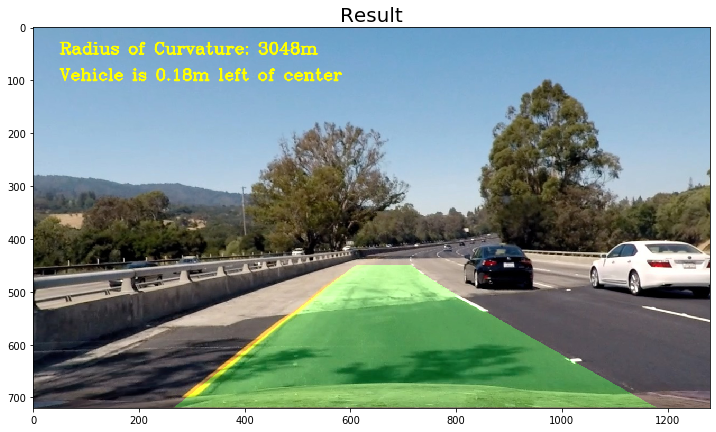

In [90]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(top_down).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(disorted_img, 1, newwarp, 0.3, 0)

plt.imshow(result)

left_curverad, right_curverad, Center_curverad, VehPos, VehLoc = measure_curvature_real(ploty, left_fit, right_fit, left_fitx, right_fitx)
cv2.putText(result, "Radius of Curvature: %dm" % Center_curverad,(50,50), cv2.FONT_HERSHEY_COMPLEX, 1,(255,255,0),2,cv2.LINE_AA)
cv2.putText(result, "Vehicle is %.2fm %s of center" % (abs(VehPos), VehLoc),(50,100), cv2.FONT_HERSHEY_COMPLEX, 1,(255,255,0),2,cv2.LINE_AA)

f, (ax1) = plt.subplots(1, 1, figsize=(15, 7))
ax1.imshow(result)
ax1.set_title('Result', fontsize=20)

### FULL PIPELINE

In [91]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pickle
import cv2
%matplotlib inline
import math
import os
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


dist_pickle = pickle.load( open( "camera_cal\dist_cal_pickle.p", "rb" ) )

In [92]:
def disortion(image,dist_pickle):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    dst = cv2.undistort(image, mtx, dist, None, mtx)

    return dst
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    if orient=='x':
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    elif orient=='y':
        scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))
        
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return grad_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir=np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return dir_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel /np.max(mag_sobel ))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mag_binary

def color_thresh(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img , cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    #return color_binary
    return s_binary
def corners_unwarp(img,src,dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    img_size=(img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)  
    return warped, M, Minv
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  
        win_xleft_high = leftx_current+margin  
        win_xright_low = rightx_current-margin 
        win_xright_high = rightx_current+margin  
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit=np.polyfit(lefty, leftx, 2) ###NOTE, NORMAL polyfit takes x first
    right_fit = np.polyfit(righty, rightx, 2) ### AXIS INVERSE

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2]
    
    return left_fitx, right_fitx, ploty


def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search

    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

def measure_curvature_real(ploty, left_fit, right_fit, left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension (from the warp destination points yend-yinit)(720-0)
    xm_per_pix = 3.7/880 # meters per pixel in x dimension (from the warp destination points xend-xinit)(1080-200)
    
       
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    
    CenterFitx = (left_fitx + right_fitx)/2 # Average of the x values from left and right lines
    CenterFit = np.polyfit(ploty, CenterFitx, 2) # Curve fit for the average x values. This calculation can also be done by taking average of curve parameters of lef and right lines
    Center_curverad = ((1 + (2*CenterFit[0]*y_eval*ym_per_pix + CenterFit[1])**2)**1.5) / np.absolute(2*CenterFit[0])
    #for sanity
    LineStoredNow.curvature_fit=CenterFit
    LineStoredNow.radius_of_curvature=Center_curverad
    #calculation of vehicle position
    MidPoint = CenterFit[0]*y_eval**2 + CenterFit[1]*y_eval + CenterFit[2] # Bottom x point of the middle curve
    
    
    VehPos = (img.shape[1]/2 - MidPoint)*xm_per_pix # Calculation of how much the vehicle is drifted from the middle of the lane

    LineStoredNow.mid_pos=VehPos
    ##SANITY CHECK
    
    if  abs(LineStoredNow.mid_pos-LineStoredHealthy.mid_pos)>0.3:
        VehPos=LineStoredHealthy.mid_pos
        Center_curverad=LineStoredHealthy.radius_of_curvature
        
    else:
        LineStoredHealthy.curvature_fit=LineStoredNow.curvature_fit
        LineStoredHealthy.mid_pos=LineStoredNow.mid_pos
        LineStoredHealthy.radius_of_curvature=LineStoredNow.radius_of_curvature
        LineStoredHealthy.leftxfitted=left_fitx
        LineStoredHealthy.rightxfitted=right_fitx
    
    if VehPos > 0:
        VehLoc = "right"
    else:
        VehLoc = "left"
    
    return left_curverad, right_curverad, Center_curverad, VehPos, VehLoc

def PlotImage(right_fitx, left_fitx, ploty, warped_img, Minv, disorted_img):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(top_down).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(disorted_img, 1, newwarp, 0.3, 0)

 

    left_curverad, right_curverad, Center_curverad, VehPos, VehLoc = measure_curvature_real(ploty, left_fit, right_fit, left_fitx, right_fitx)
    cv2.putText(result, "Radius of Curvature: %dm" % Center_curverad,(50,50), cv2.FONT_HERSHEY_COMPLEX, 1,(255,255,0),2,cv2.LINE_AA)
    cv2.putText(result, "Vehicle is %.2fm %s of center" % (abs(VehPos), VehLoc),(50,100), cv2.FONT_HERSHEY_COMPLEX, 1,(255,255,0),2,cv2.LINE_AA)

    return result

In [93]:
def ImageProcess(img):

    disorted_img=disortion(img, dist_pickle)

    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    gradx = abs_sobel_thresh(disorted_img, orient='x', sobel_kernel=9, thresh=(30, 255))
    grady = abs_sobel_thresh(disorted_img, orient='y', sobel_kernel=9, thresh=(50, 200))

    dir_tr=dir_threshold(disorted_img,sobel_kernel=9, thresh=(0.8, 1.2))  #(0, np.pi/2))
    mag_tr=mag_thresh(disorted_img,sobel_kernel=3, mag_thresh=(25, 200)) #(40, 90)

    color_tr=color_thresh(disorted_img,s_thresh=(170, 255),sx_thresh=(20, 100))

    combined = np.zeros_like(dir_tr)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_tr == 1) & (dir_tr == 1))] = 1
    combined[((gradx == 1) & (grady == 1)) |  (color_tr==1)| ((mag_tr == 1) & (dir_tr == 1))] = 1


    
    src = np.float32(
        [[ 150, 720],
         [590,450],
         [720, 450],
        [1190, 720]])
    dst = np.float32(
                [[200,720],
                 [200,0],
                 [1080,0],
                 [1080,720]])

    top_down, perspective_M, Minv = corners_unwarp(combined,src,dst)

    out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(top_down)

    ## alternativly    result = search_around_poly(top_down)

    # Calculate the radius of curvature in meters for both lane lines
    left_curverad, right_curverad, Center_curverad, VehPos, VehLoc = measure_curvature_real(ploty, left_fit, right_fit, left_fitx, right_fitx)
    
    UpdatedImage=PlotImage(LineStoredHealthy.rightxfitted, LineStoredHealthy.leftxfitted, ploty, top_down, Minv, disorted_img)
        
    return UpdatedImage

In [94]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.leftxfitted = []
        self.rightxfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.curvature_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.mid_pos = 0 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

In [95]:
LineStoredHealthy = Line()
LineStoredNow = Line()

### TESTING!!

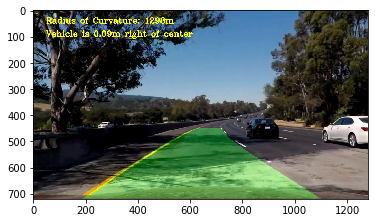

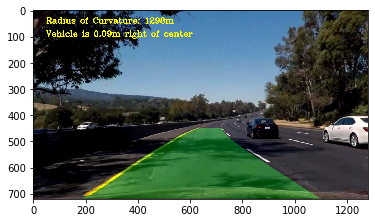

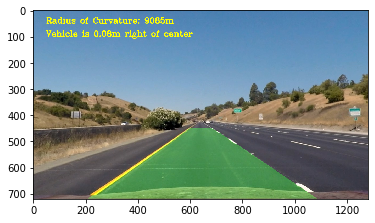

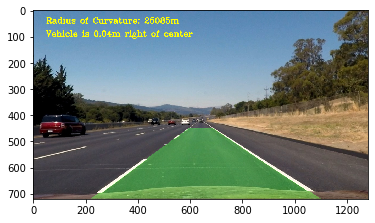

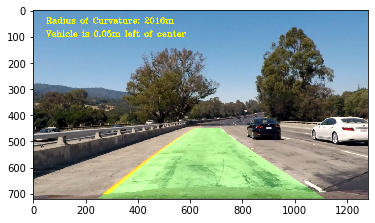

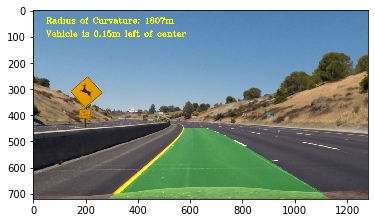

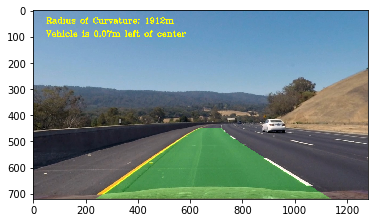

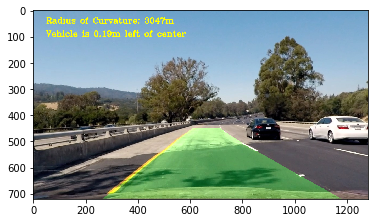

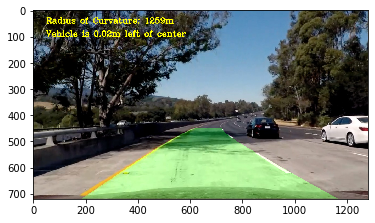

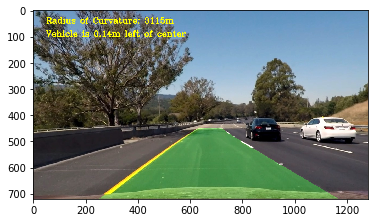

In [26]:
   
ReadDirectory = 'test_images/'
SaveDirectory = 'output_images/'
for file in os.listdir(ReadDirectory): 
    image = mpimg.imread(ReadDirectory+file)
    imageOut = ImageProcess(image)
    plt.imshow(imageOut) 
    plt.show()
    cv2.imwrite(SaveDirectory+file, cv2.cvtColor(imageOut, cv2.COLOR_BGR2RGB))   
    

In [96]:
### This section allows to load project video and process it to find lane lines. Video will be played after saving the file.
from moviepy.editor import VideoFileClip
output = 'test_video_output/'+'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip('project_video.mp4').subclip(0,50)
clip = clip1.fl_image(ImageProcess) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

Moviepy - Building video test_video_output/project_video_output.mp4.
Moviepy - Writing video test_video_output/project_video_output.mp4



Moviepy - Done !
Moviepy - video ready test_video_output/project_video_output.mp4
Wall time: 6min 9s


In [37]:
clip1.save_frame("frame3base.jpg", t = 41.6) ## this frame was problematic for my thresholds. Thus I saved it with this function and recalibrated my combined thresholds by adding this frame at test images folder.

In [29]:
from IPython.display import HTML
HTML("""<video width="1280" height="720" controls><source src="{0}"></video>""".format("project_video_output.mp4"))

In [30]:
#cv2.imwrite('output_images/test4_dst.jpg',cv2.cvtColor(mag_tr,  cv2.COLOR_RGB2GRAY))
